### LSTM Autoencoder for Anomaly Detection for ECG Data

An LSTM Autoencoder is an implementation of an autoencoder for sequence data using an Encoder-Decoder LSTM architecture. For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performace of the model is evaluated based on the model's ability to recreate the input sequence. Once the model achieves a desired level of performace recreating the sequence, the decoder part of the model may be remove, leaving just the encoder model. This model can then be used to encode input sequences to a fixed-length vector.

The resulting vectors can then be used in a variety of applications, not least as a compressed representation of the sequence as an input to another supervised learning model.

The Autoencoder's job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temportal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat us considered abnormal.

Reconstruction Loss when training an Autocoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.

We are going to look at the original dataset for <a href = 'http://www.timeseriesclassification.com/description.php?Dataset=ECG5000'>ECG5000</a> which is a 20-hour long ECG downloaded from Physionet.

#### Downloading all of the dependencies

In [100]:
import seaborn as sns
import matplotlib as mpl 
import numpy as np
import torch
from scipy.io.arff import loadarff
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


%matplotlib inline 
%config InlineBackend.figure_format ='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
mpl.rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Load Training and test data as pandas

In [102]:
with open('ECG5000/ECG5000_TRAIN.arff') as f:
    raw_data = loadarff(f)
    train = pd.DataFrame(raw_data[0])

with open('ECG5000/ECG5000_TEST.arff') as f:
    raw_data1 = loadarff(f)
    test = pd.DataFrame(raw_data1[0])
test.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,b'1'
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,b'1'
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,b'1'
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,b'1'
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,b'1'


Next, we need to append the train and test dataset

In [103]:
frames = [train, test]
df = pd.concat(frames)
df.shape

(5000, 141)

We need to shuffle the dataset to insure there is no ordering.

In [104]:
df = df.sample(frac = 1.0)

Data the dataset contains 5000 Time Series examples (obtained with ECG with 140 timesteps). Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heartbeat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. 

We have 5 types of heartbeats(classes):
1. Normal (N)
2. Premature Ventricular Contraction (PVC)
3. R-on-T Premature Ventricular Contraction (R-on-T PVC)
4. Supra-ventricular Premature or Ectopic Beat (SP or EB)
5. Unclassified Beat (UB).

Assuming a healthy heart and a typical rate of 70 or 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60-100 per minute (Humans) Duration: 0.6-1 second (Humans). We will be working with the normal data set.



In [105]:
class_names = ['Normal', 'PVC', "R on T", "SP", "UB"]
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

Next, we need to do an exploratory data analysis and look at the visualization of the defects.

In [106]:
df.target.value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

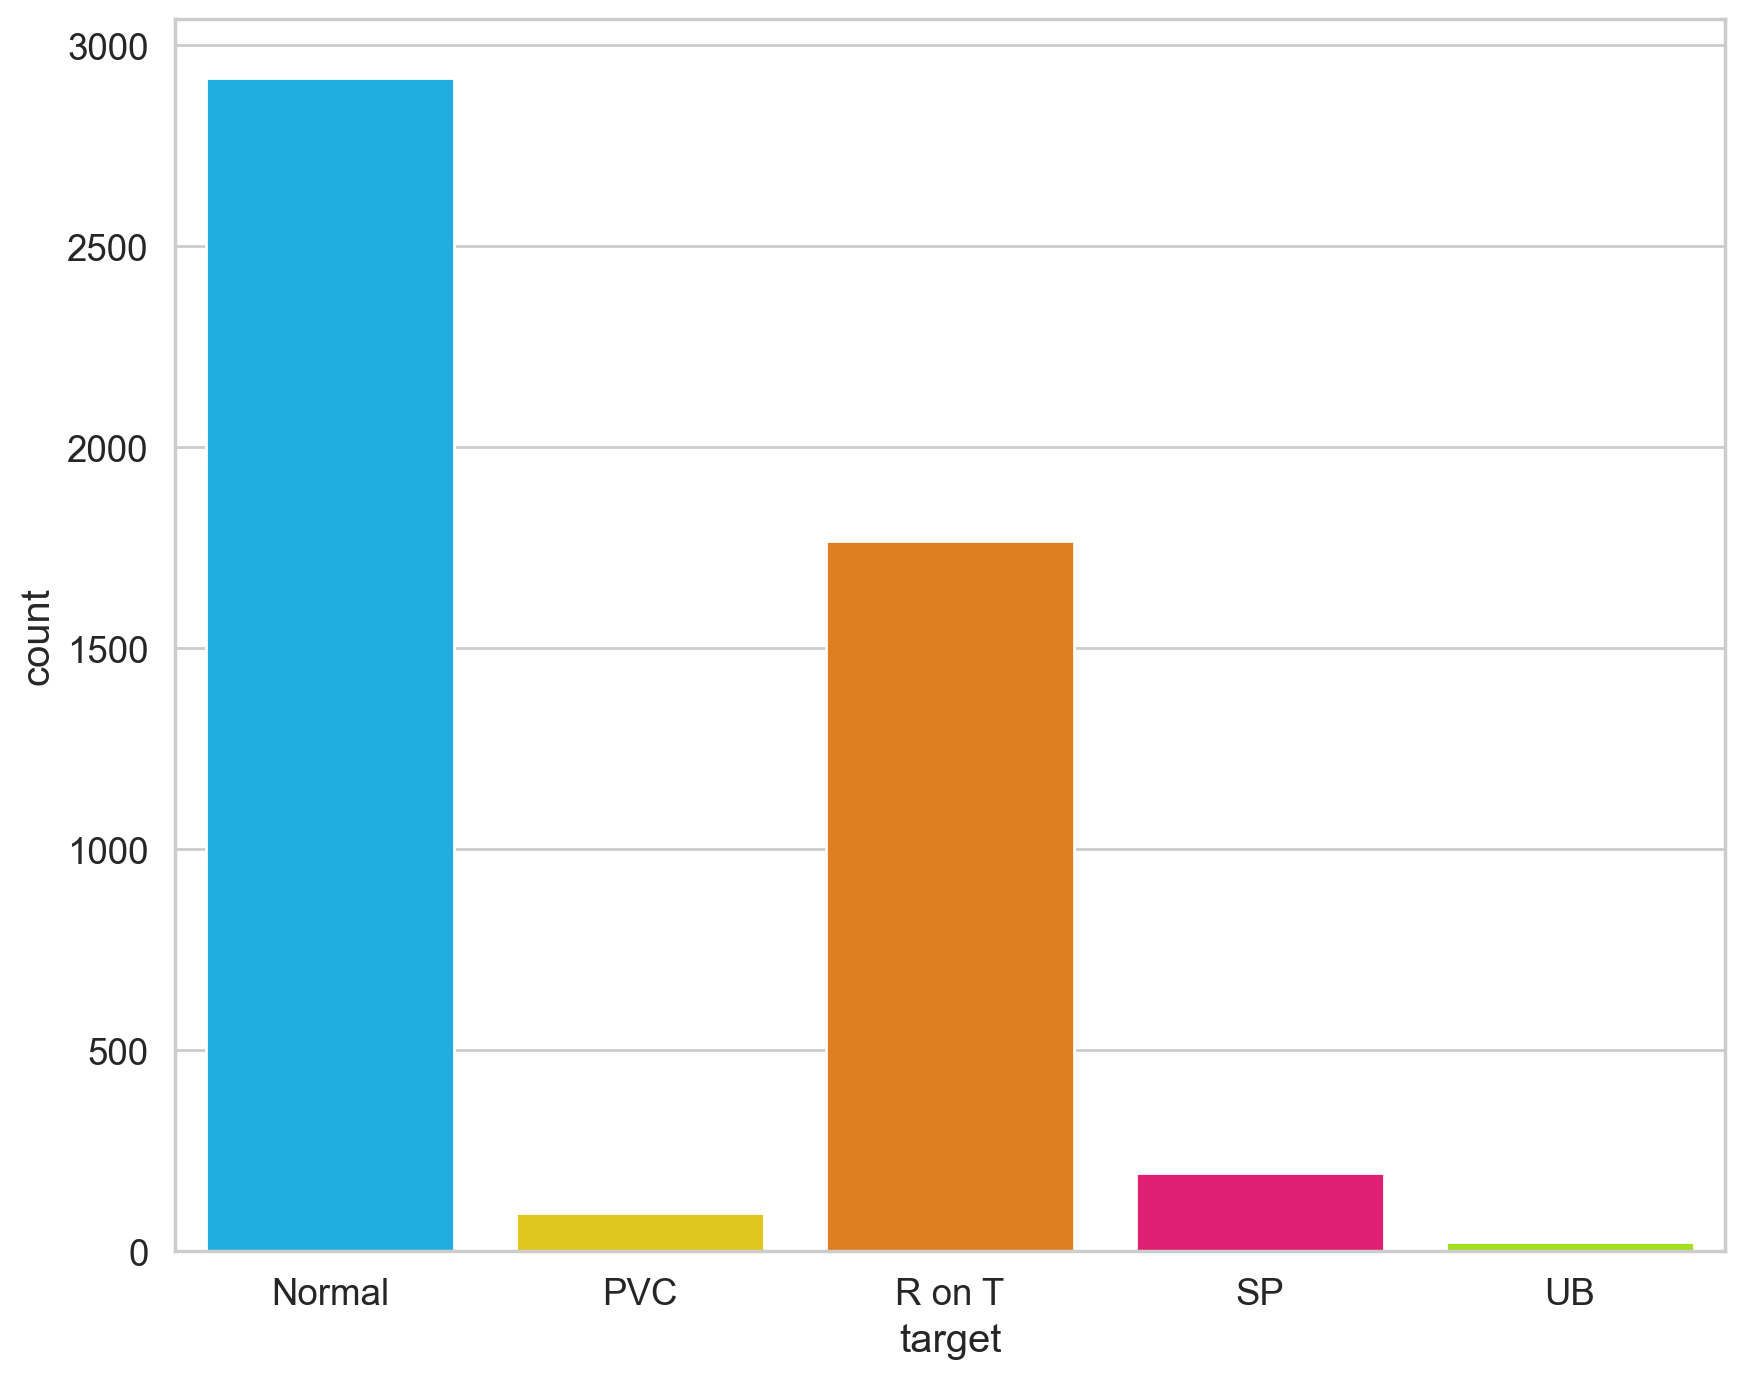

In [107]:
ax = plt.figure(figsize = (10 , 8))
ax = sns.countplot(x = df.target)
ax.set_xticklabels(class_names)

plt.show()

As we can see from the model, the normal class has the highest dataset approx.2919. We can use this to train our model. We can also look at averaged time-series data each class.

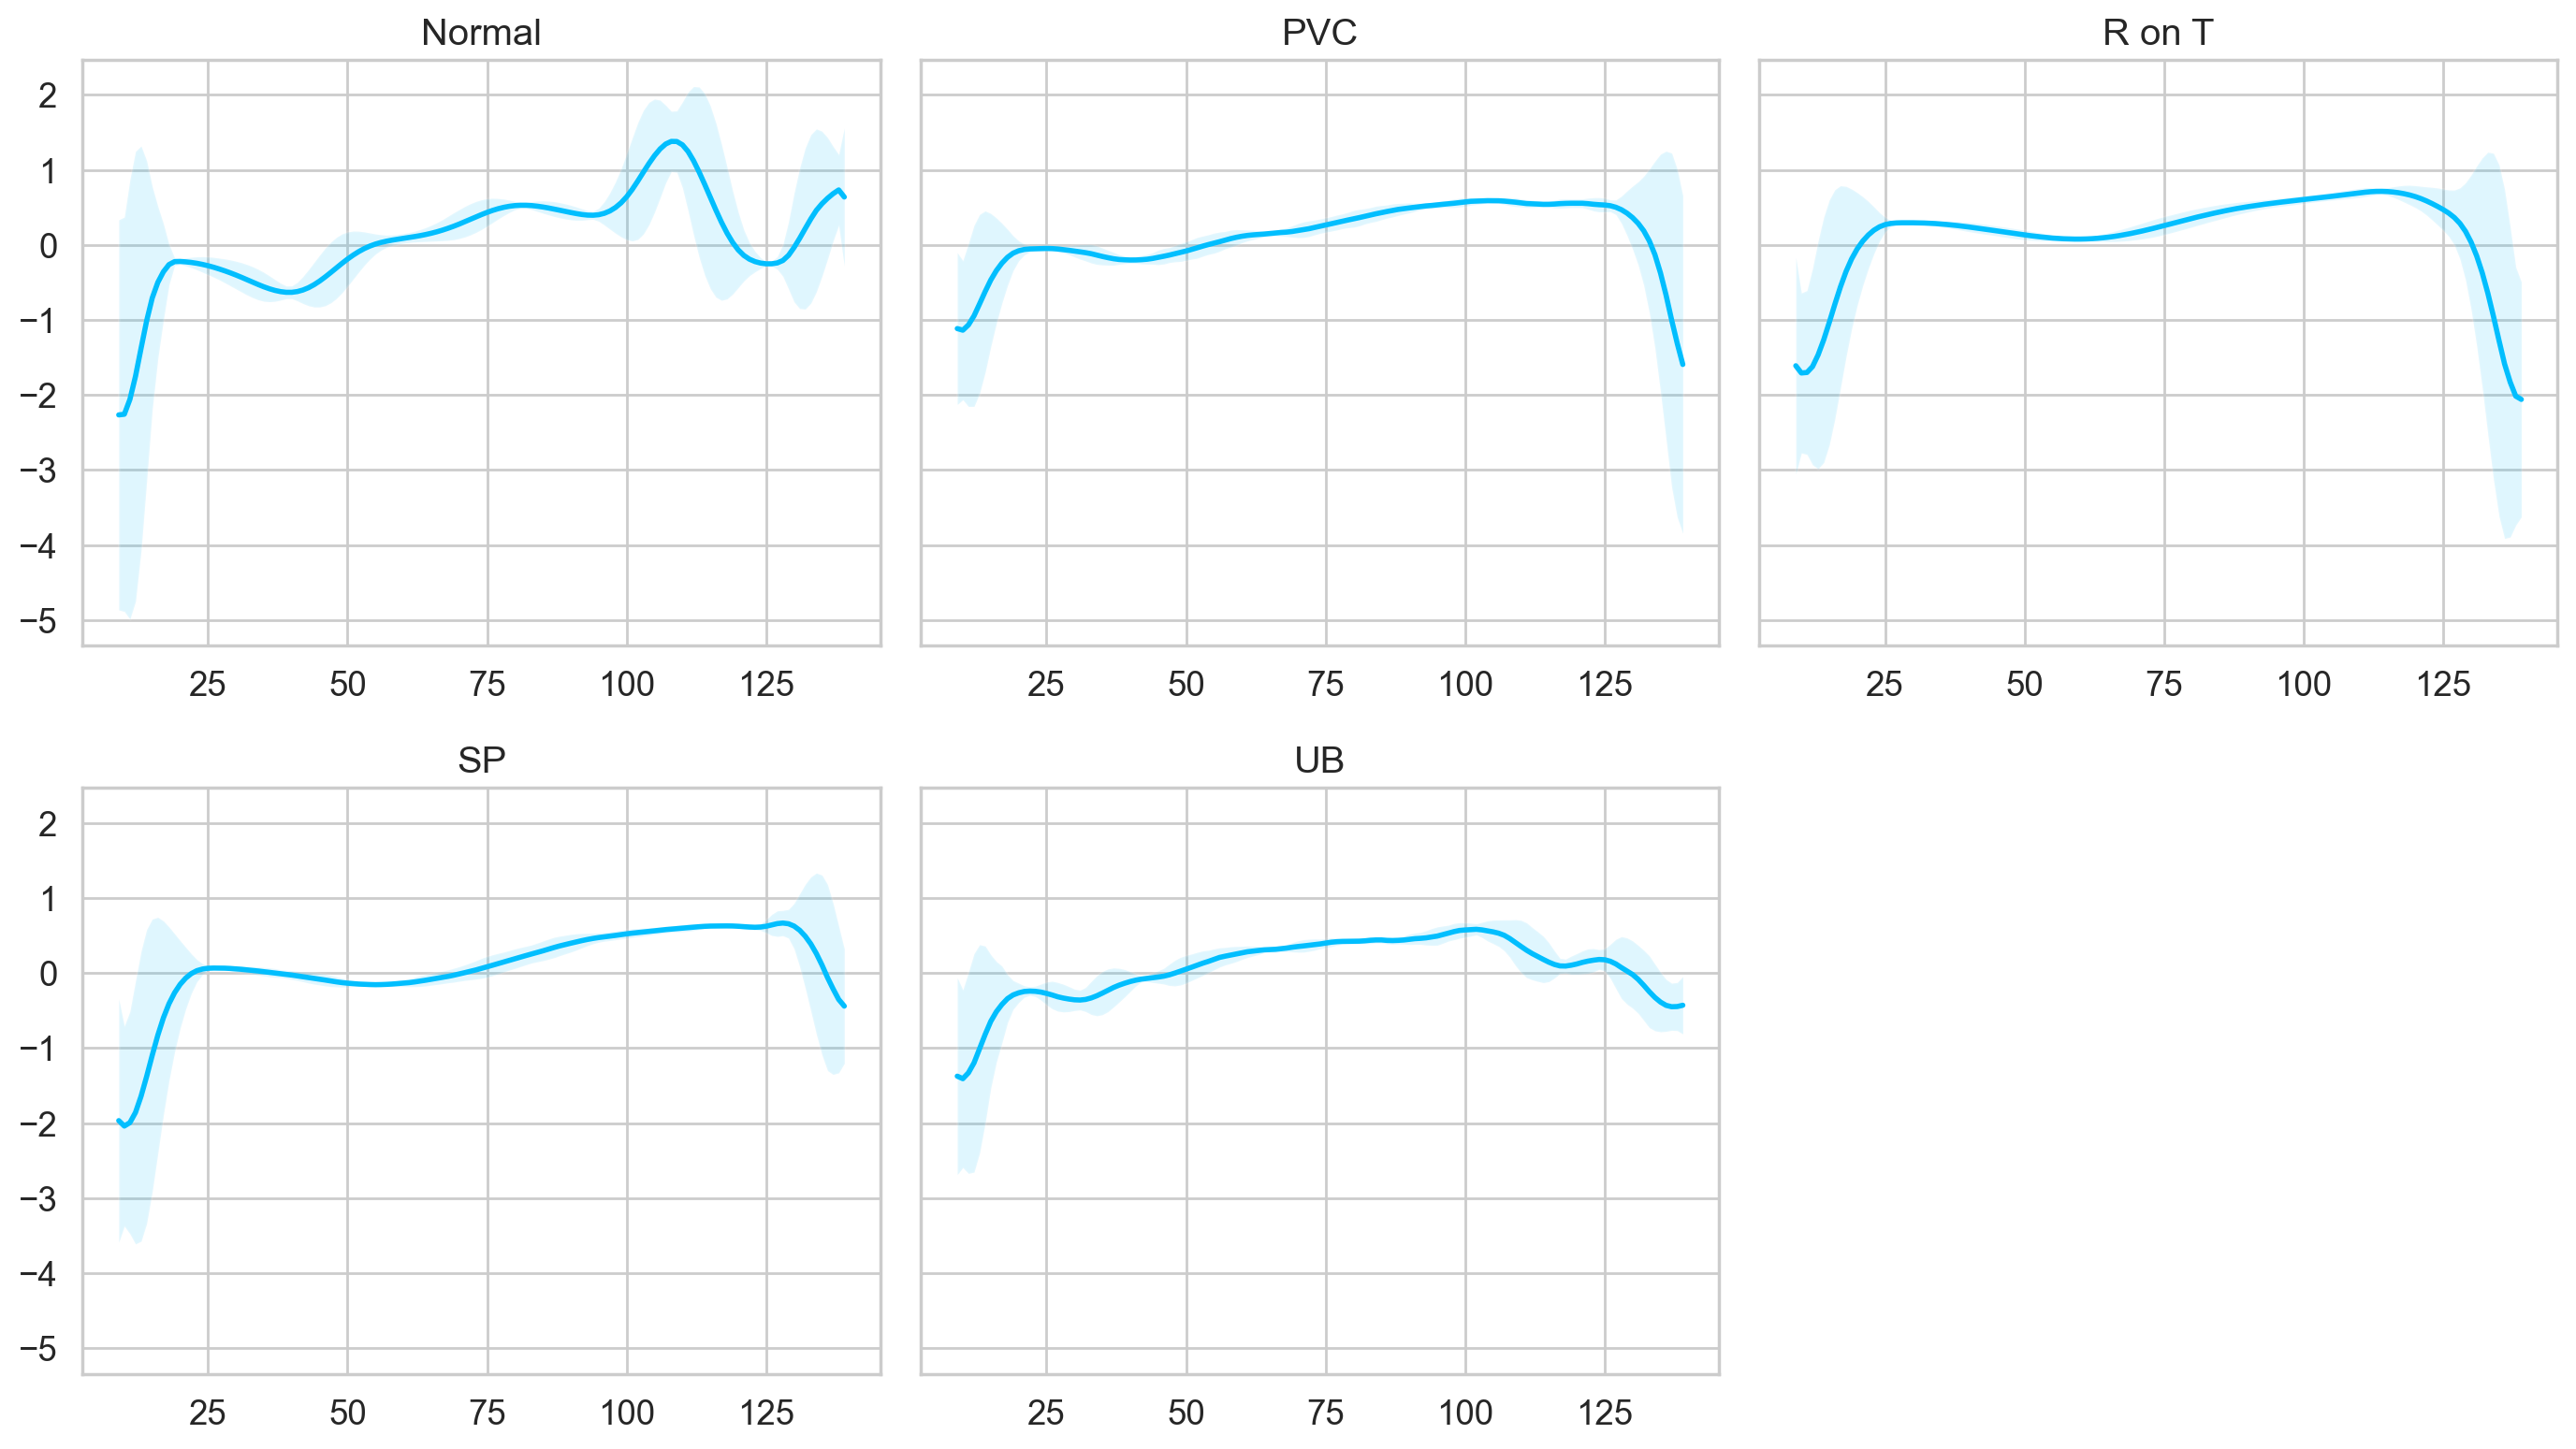

In [108]:
def plot_time_series_class(data, class_name, ax, n_steps = 10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth = 2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha = .125
    )
    ax.set_title(class_name)


classes = df.target.unique()

fig, axs = plt.subplots(
        nrows = len(classes) // 3 + 1,
        ncols = 3,
        sharey = True,
        figsize = (14 , 8)
    )

for i, cls in enumerate(classes):
        ax = axs.flat[i]
        data = df[df.target == cls] \
            .drop(labels = 'target', axis = 1) \
            .mean(axis = 0) \
            .to_numpy()
        plot_time_series_class(data, class_names[i], ax)
fig.delaxes(axs.flat[-1])
fig.tight_layout()
        

Anomaly Detection in ECG data. We'll use normal heartbeats as training data for our model and record the reconstruction loss. But first, we need to prepare the data. 
**Data Preprocessing**: Let's get all normal heartbeats and drop the target(class) column. We need all normal heartbeats and drop the target(class) column.

In [109]:
normal_df = df[df.target == b'1'].drop(labels = 'target', axis = 1)
normal_df.shape

(2919, 140)

We need to merge all the other classes and mark them as anomalies

In [110]:
anomaly_df = df[df.target != b'1'].drop(labels = 'target', axis = 1)
anomaly_df.shape

(2081, 140)

Let's split the normal examples into the train, test and validation dataset.

In [111]:
train_df, val_df = train_test_split(
    normal_df,
    test_size = 0.15,
    random_state = RANDOM_SEED
)

val_df, test_df = train_test_split(
    val_df,
    test_size = 0.33,
    random_state = RANDOM_SEED  
)

In [112]:
train_df.shape, val_df.shape, test_df.shape

((2481, 140), (293, 140), (145, 140))

We now need to convert our examples into tensors

In [113]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length X number of features (140 x 1 in our case).

In [114]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

The theory behind the autoencoders is try to reduce the dimensionality of the dataset and increase the dimensionality through autoencoding. During the reconstruction phase, the model tries to reconstruct the heartbeat data normally. As we provide the anomaly data to the model, the reconstruction error is high as the error is propagated showing the anomalies which are what we are looking for. The general Autoencoder architecture consists of two components. An Encoder compresses the input and a Decoder that tries to construct it. 

### Building the Encoder

This code defines a PyTorch module called `Encoder`, which consists of two separate layers of LSTM (Long Short-Term Memory) recurrent neural networks (RNNs). An LSTM is a type of RNN that is capable of capturing long-range dependencies in sequential data. The purpose of this `Encoder` module is to process input sequences and produce a compressed representation of the input data, which is often used in various tasks like sequence-to-sequence modeling, language translation, and more.

Here's a breakdown of the code:

1. Importing Required Libraries:
   The code should begin with importing the necessary libraries. It seems that the required `nn` (neural network) module from the PyTorch library is used in this code.

2. `Encoder` Class Definition:
   - The `Encoder` class is defined, inheriting from the `nn.Module` base class.
   - The constructor (`__init__`) of the `Encoder` class takes three parameters:
     - `seq_len`: The length of the input sequences.
     - `n_features`: The number of features in each time step of the input sequences.
     - `embedding_dim`: The dimensionality of the embedding space. The default is set to 64.

3. Inside the Constructor:
   - The constructor initializes various attributes like `seq_len`, `n_features`, `embedding_dim`, and `hidden_dim` (which is twice the `embedding_dim`).
   - Two layers of LSTM cells are defined:
     - `rnn1`: The first LSTM layer, which takes input of size `n_features` and produces an output of size `hidden_dim`.
     - `rnn2`: The second LSTM layer, which takes input of size `hidden_dim` and produces an output of size `embedding_dim`.
   - Both LSTM layers have a single layer and use `batch_first=True`, which means that the input tensor's shape should have the batch size as the first dimension.

4. `forward` Method:
   - This method defines the forward pass through the `Encoder`.
   - The input tensor `x` is reshaped to have dimensions `(1, seq_len, n_features)` to match the expected input shape for the LSTM layers.
   - The input tensor `x` is then passed through `rnn1`. The output `x` and the last hidden state are captured, but only the hidden state is stored in `_` since it won't be used.
   - The output `x` from `rnn1` is then passed through `rnn2`. The output `x` and the last hidden state are again captured, but this time, only the last hidden state is stored in `hidden_n`.
   - The `hidden_n` tensor is reshaped to have dimensions `(n_features, embedding_dim)` and returned. This tensor can be interpreted as the encoded representation of the input sequence.

5. Overall Purpose:
   The purpose of this `Encoder` module is to take an input sequence, process it through two layers of LSTM cells, and return a compressed representation of the input sequence in the `embedding_dim`-dimensional space.

6. Potential Improvement:
   One thing to note is that the implementation is currently designed to work with single input sequences. If you intend to process multiple sequences in parallel (batch processing), you might need to adjust the input shape and how you handle the hidden states.

Please keep in mind that for successful execution of this code, you would need to have the required libraries imported (`nn` from PyTorch) and any other parts of the code that might be responsible for data preparation and model training.

In [115]:
#Encoder is 2 separate layers of the LSTM RNN 
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim = 64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
  # Initializing the hidden numbers of layers
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

We optimize the parameters of our Autoencoder model in such a way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used. The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we’ll decode the compressed representation using a Decoder. And increase the dimensionality of the layer.

### Building the Decoder

This code defines a PyTorch module called `Decoder`, which is intended to work in conjunction with an encoder to complete a sequence-to-sequence model, possibly for tasks like sequence generation, language translation, etc. The `Decoder` generates an output sequence based on the encoded representation obtained from the `Encoder`.

Here's a breakdown of the code:

1. Importing Required Libraries:
   It is assumed that the required `nn` (neural network) module from the PyTorch library has already been imported.

2. `Decoder` Class Definition:
   - The `Decoder` class is defined, inheriting from the `nn.Module` base class.
   - The constructor (`__init__`) of the `Decoder` class takes three parameters:
     - `seq_len`: The length of the output sequence to be generated.
     - `input_dim`: The dimensionality of the input to the decoder (usually corresponds to the embedding dimension of the encoder). The default is set to 64.
     - `n_features`: The number of features in each time step of the output sequence. The default is set to 1.

3. Inside the Constructor:
   - The constructor initializes various attributes like `seq_len`, `input_dim`, `hidden_dim` (twice the `input_dim`), and `n_features`.
   - Two layers of LSTM cells are defined:
     - `rnn1`: The first LSTM layer, which takes input of size `input_dim` and produces an output of size `input_dim`. This can be seen as an initial transformation of the encoded input.
     - `rnn2`: The second LSTM layer, which takes input of size `input_dim` and produces an output of size `hidden_dim`. This can be seen as a more complex transformation to capture dependencies for generating the output sequence.
   - An output layer (fully connected linear layer) is defined using `nn.Linear`:
     - The output layer maps the hidden dimension to the desired output feature dimension (`n_features`).

4. `forward` Method:
   - This method defines the forward pass through the `Decoder`.
   - The input tensor `x` (which is usually the encoded representation from the `Encoder`) is repeated along the time dimension to match the desired output sequence length (`seq_len`).
   - The repeated tensor `x` is then reshaped to have dimensions `(n_features, seq_len, input_dim)` to match the expected input shape for the LSTM layers.
   - The input tensor `x` is passed through `rnn1`. The output `x` and the last hidden state and cell state are captured in `(hidden_n, cell_n)`.
   - The output `x` from `rnn1` is then passed through `rnn2`. The output `x` and the last hidden state and cell state are again captured in `(hidden_n, cell_n)`.
   - The output tensor `x` from `rnn2` is reshaped to have dimensions `(seq_len, hidden_dim)` and passed through the output layer to generate the final output sequence.

5. Overall Purpose:
   The purpose of this `Decoder` module is to take an encoded input, process it through two layers of LSTM cells, and generate an output sequence using an output layer.

6. Note:
   Like with the `Encoder` module, it's important to ensure that the input shapes and dimensions are appropriately handled in the context of a larger model. The usage and interaction of the `Encoder` and `Decoder` would typically be part of a more comprehensive sequence-to-sequence model for tasks such as sequence generation.

In [116]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
#Using a dense layer as an output layer
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

In [117]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

  def save_model(self, filepath):
    torch.save(self.state_dict(), filepath)
    print("Model saved.")


Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it

In [118]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

### Building a training model

This code defines a function `train_model` to train a PyTorch model using a specified training dataset and validation dataset. The training process involves iterating through epochs, optimizing the model's parameters, and evaluating the model's performance on both the training and validation datasets.

Here's a step-by-step breakdown of the code:

1. **Function Signature:**
   The function `train_model` takes four parameters:
   - `model`: The PyTorch model to be trained.
   - `train_dataset`: The dataset for training.
   - `val_dataset`: The dataset for validation.
   - `n_epochs`: The number of training epochs.

2. **Optimizer and Loss Function:**
   - An Adam optimizer is created using the model's parameters with a learning rate of 1e-3.
   - A mean absolute error (L1 loss) criterion is defined for measuring the difference between predicted and true sequences. The reduction is set to 'sum', meaning the individual losses are summed up.

3. **History and Best Model Initialization:**
   - A dictionary named `history` is created to store the training and validation losses for each epoch.
   - The current model's weights are deep-copied to `best_model_wts`, and an initial best loss (`best_loss`) is set to a high value.

4. **Training Loop:**
   The training process involves looping through the specified number of epochs.

   a. The model is set to training mode using `model = model.train()`.

   b. `train_losses` is a list to store the training losses for each sequence in the training dataset.
   
   c. For each sequence `seq_true` in the training dataset:
      - The optimizer's gradients are zeroed using `optimizer.zero_grad()`.
      - `seq_true` is moved to the appropriate device (assuming the device is previously defined).
      - The model makes predictions `seq_pred` based on the input `seq_true`.
      - The loss is calculated using the defined loss criterion.
      - Backpropagation is performed to compute gradients using `loss.backward()`.
      - The optimizer updates the model's parameters using `optimizer.step()`.
      - The current loss is appended to `train_losses`.

5. **Validation Loop:**
   a. The model is set to evaluation mode using `model = model.eval()`.

   b. `val_losses` is a list to store the validation losses for each sequence in the validation dataset.

   c. For each sequence `seq_true` in the validation dataset:
      - Similar to the training loop, the input sequence is moved to the appropriate device.
      - Predictions are generated using the model.
      - The loss is calculated for the validation set.

6. **Calculating Mean Loss and History Update:**
   - The mean of training losses (`train_loss`) and validation losses (`val_loss`) are calculated.
   - The average losses for both training and validation are added to the `history` dictionary.

7. **Updating Best Model and Printing Progress:**
   - If the current validation loss (`val_loss`) is better (lower) than the previously best validation loss (`best_loss`), the current model's weights are deep-copied to `best_model_wts`, and `best_loss` is updated.
   - The progress of each epoch is printed, showing the epoch number, training loss, and validation loss.

8. **Loading Best Model and Returning:**
   - After all epochs are completed, the model's state dictionary is updated with the weights of the best model (`best_model_wts`).
   - The function returns the best model in evaluation mode along with the `history` dictionary containing training and validation losses.

This code demonstrates a typical training loop for a PyTorch model, including training and validation phases, loss calculation, and best model selection based on validation performance. The returned best model can be further used for making predictions or other tasks.

In [119]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

#Next We need to evaluate the dataset 

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

Finally, we run the model

In [120]:
model, history = train_model(model, train_dataset, val_dataset, n_epochs = 100)

Epoch 1: train loss 66.04172776640063 val loss 55.04166843297131
Epoch 2: train loss 49.671157223425865 val loss 52.29734835445677
Epoch 3: train loss 46.56170752854753 val loss 56.32026600756336
Epoch 4: train loss 50.76287364998156 val loss 49.41809807865286
Epoch 5: train loss 49.1072908914267 val loss 48.056316701218535
Epoch 6: train loss 44.19734824294767 val loss 37.47382478421052
Epoch 7: train loss 40.023902042793296 val loss 39.8952867944086
Epoch 8: train loss 36.508295295989015 val loss 40.10699168000205
Epoch 9: train loss 40.15931383461204 val loss 44.105902102213264
Epoch 10: train loss 45.615752173642484 val loss 49.303085222992884
Epoch 11: train loss 49.756902560934044 val loss 48.363301221828
Epoch 12: train loss 44.27789830335058 val loss 36.66942998736385
Epoch 13: train loss 33.957395761544454 val loss 28.459191354875273
Epoch 14: train loss 29.922049074584272 val loss 31.889068544928126
Epoch 15: train loss 28.560865963432683 val loss 25.93432648434167
Epoch 16: 

### Saving the model

In [134]:
# Call the save_model function to save the model to a file
model.save_model("model_100_epochs.pth")

Model saved.


### Loading the model

In [135]:
# Load the saved model's state dictionary
saved_model_path = "model_100_epochs.pth"
model.load_state_dict(torch.load(saved_model_path))
model.eval()  # Set the model to evaluation mode

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [136]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/var/folders/_9/wkm0tqns0n53w3ytpgc_68kc0000gn/T/ipykernel_666/3614772348.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True)


<Axes: ylabel='Density'>

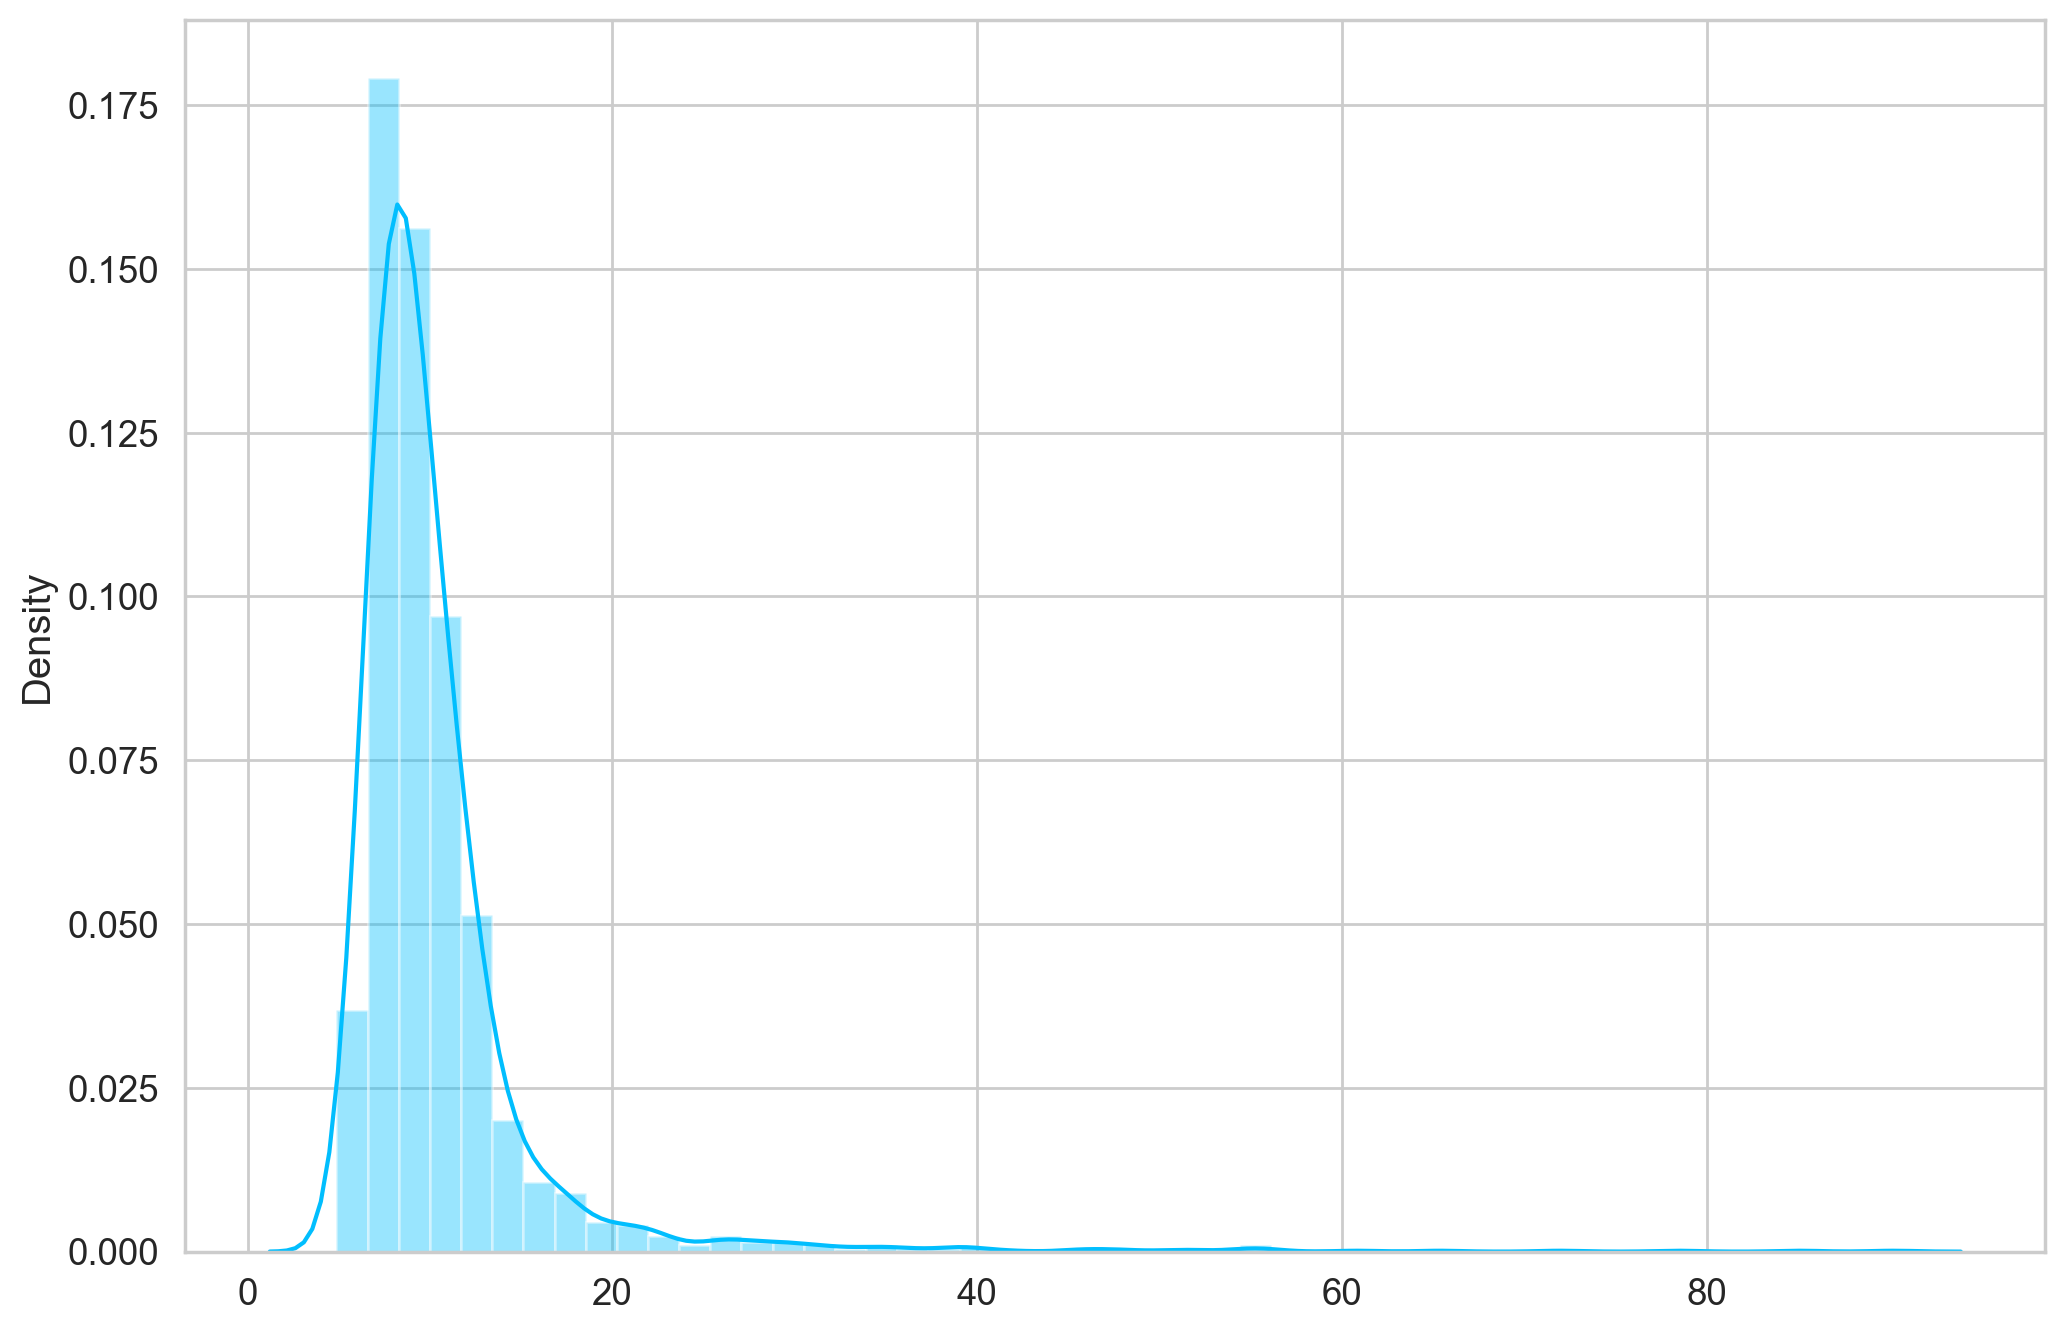

In [137]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True)

Evaluation using the threshold, we can turn the problem into a simple binary classification task:

If the reconstruction loss for example is below the threshold, we'll classify it as a normal heartbeat. Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly heartbeats. Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model hasn't seen those).

/var/folders/_9/wkm0tqns0n53w3ytpgc_68kc0000gn/T/ipykernel_666/2420475909.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins = 50, kde = True)


<Axes: ylabel='Density'>

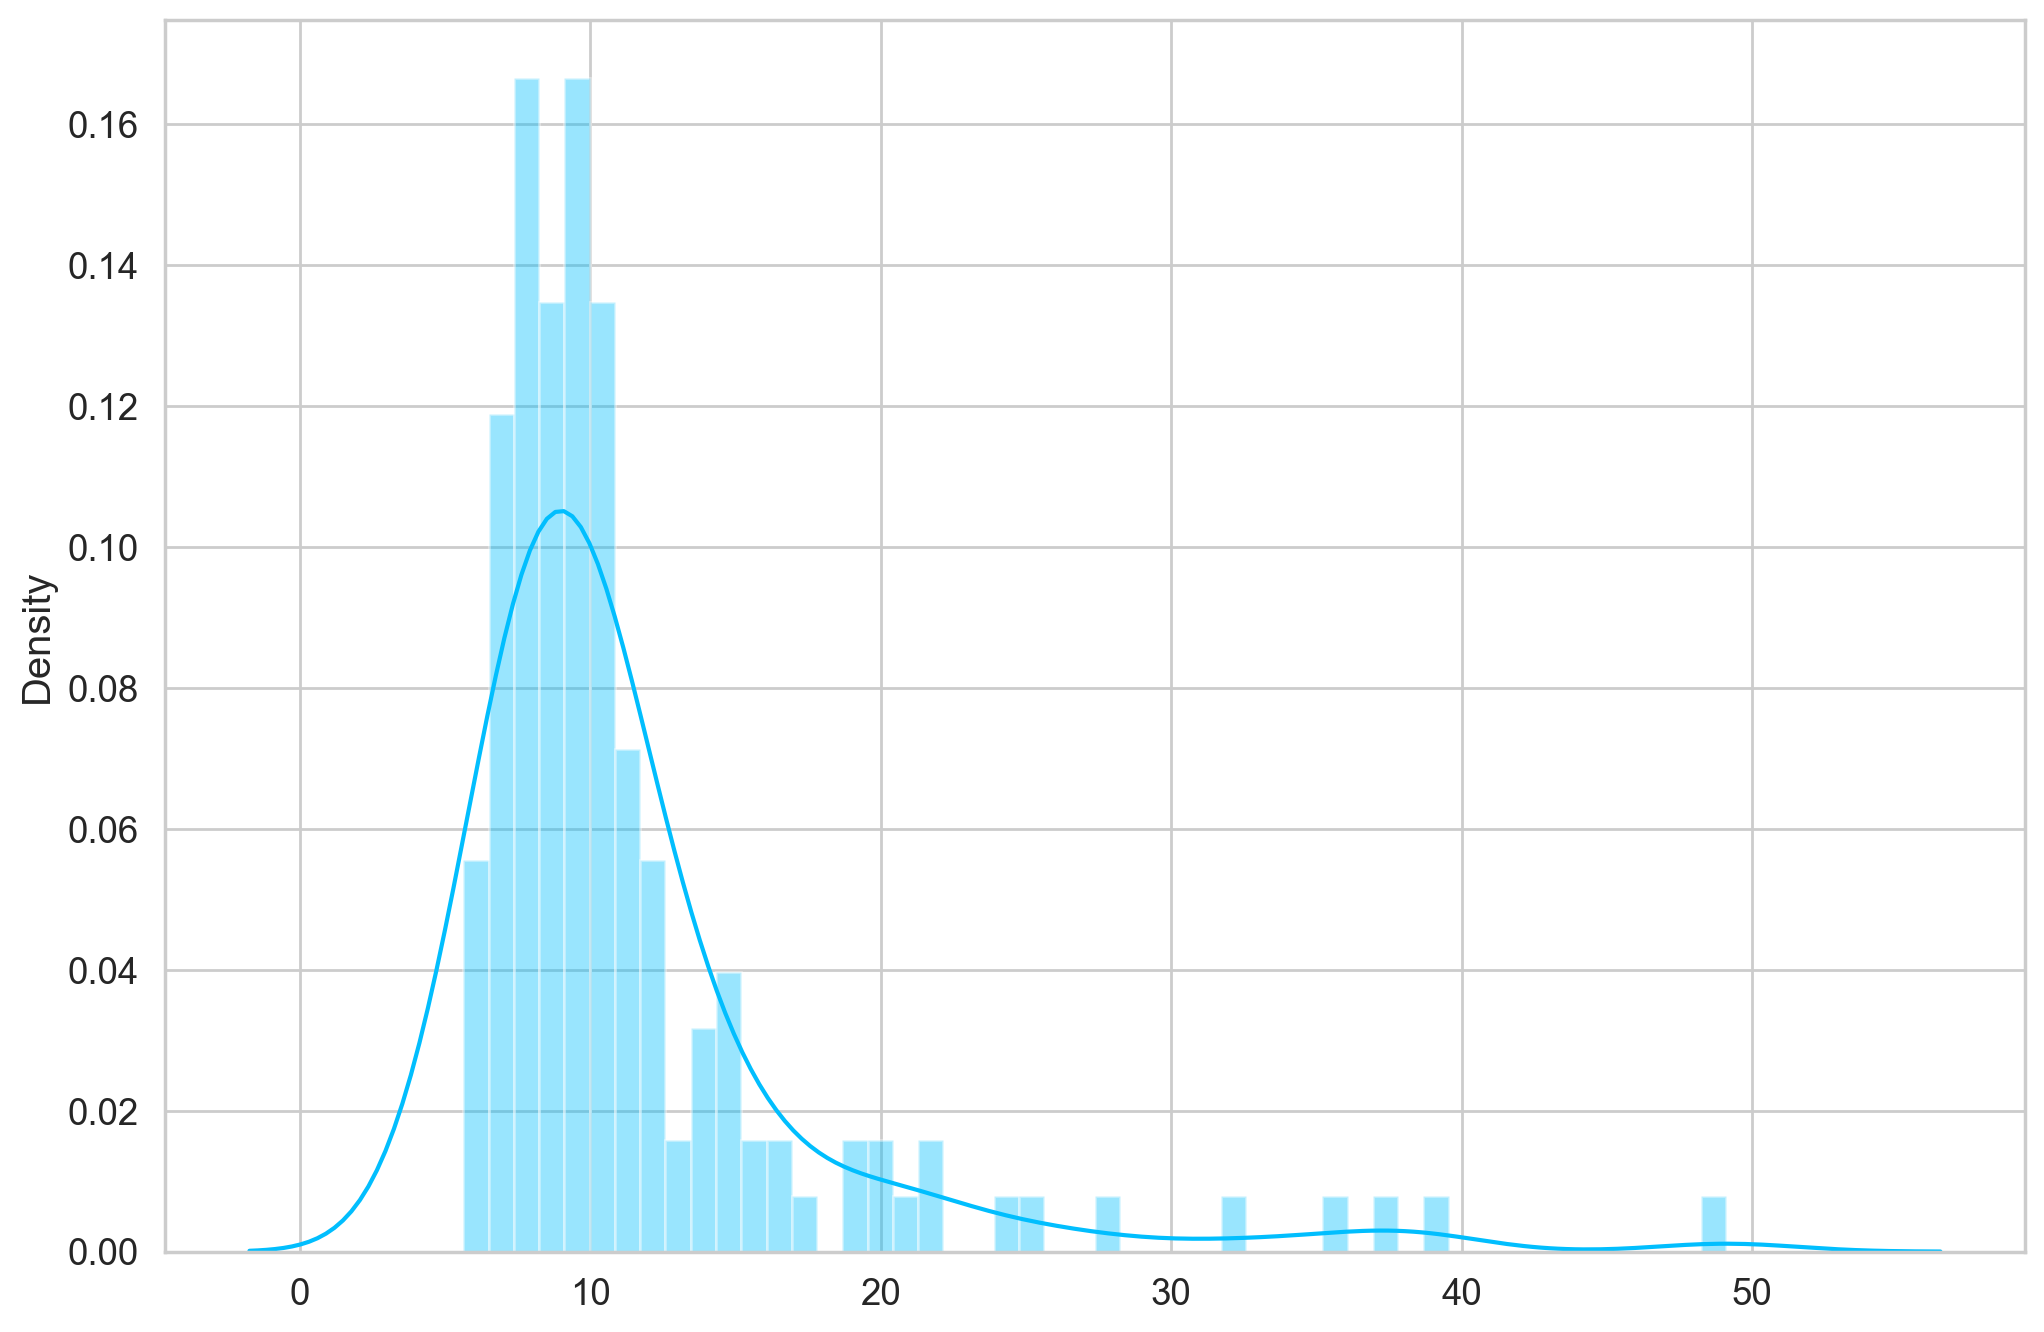

In [138]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins = 50, kde = True)

We can count the predictions

In [139]:
THRESHOLD = 26

In [140]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 139/145


Similarly, we can look at the anomalies examples but their number is much higher. We'll get a subset that has the same size as the normal heartbeats.

In [141]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies.

/var/folders/_9/wkm0tqns0n53w3ytpgc_68kc0000gn/T/ipykernel_666/1928515029.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins = 50, kde = True)


<Axes: ylabel='Density'>

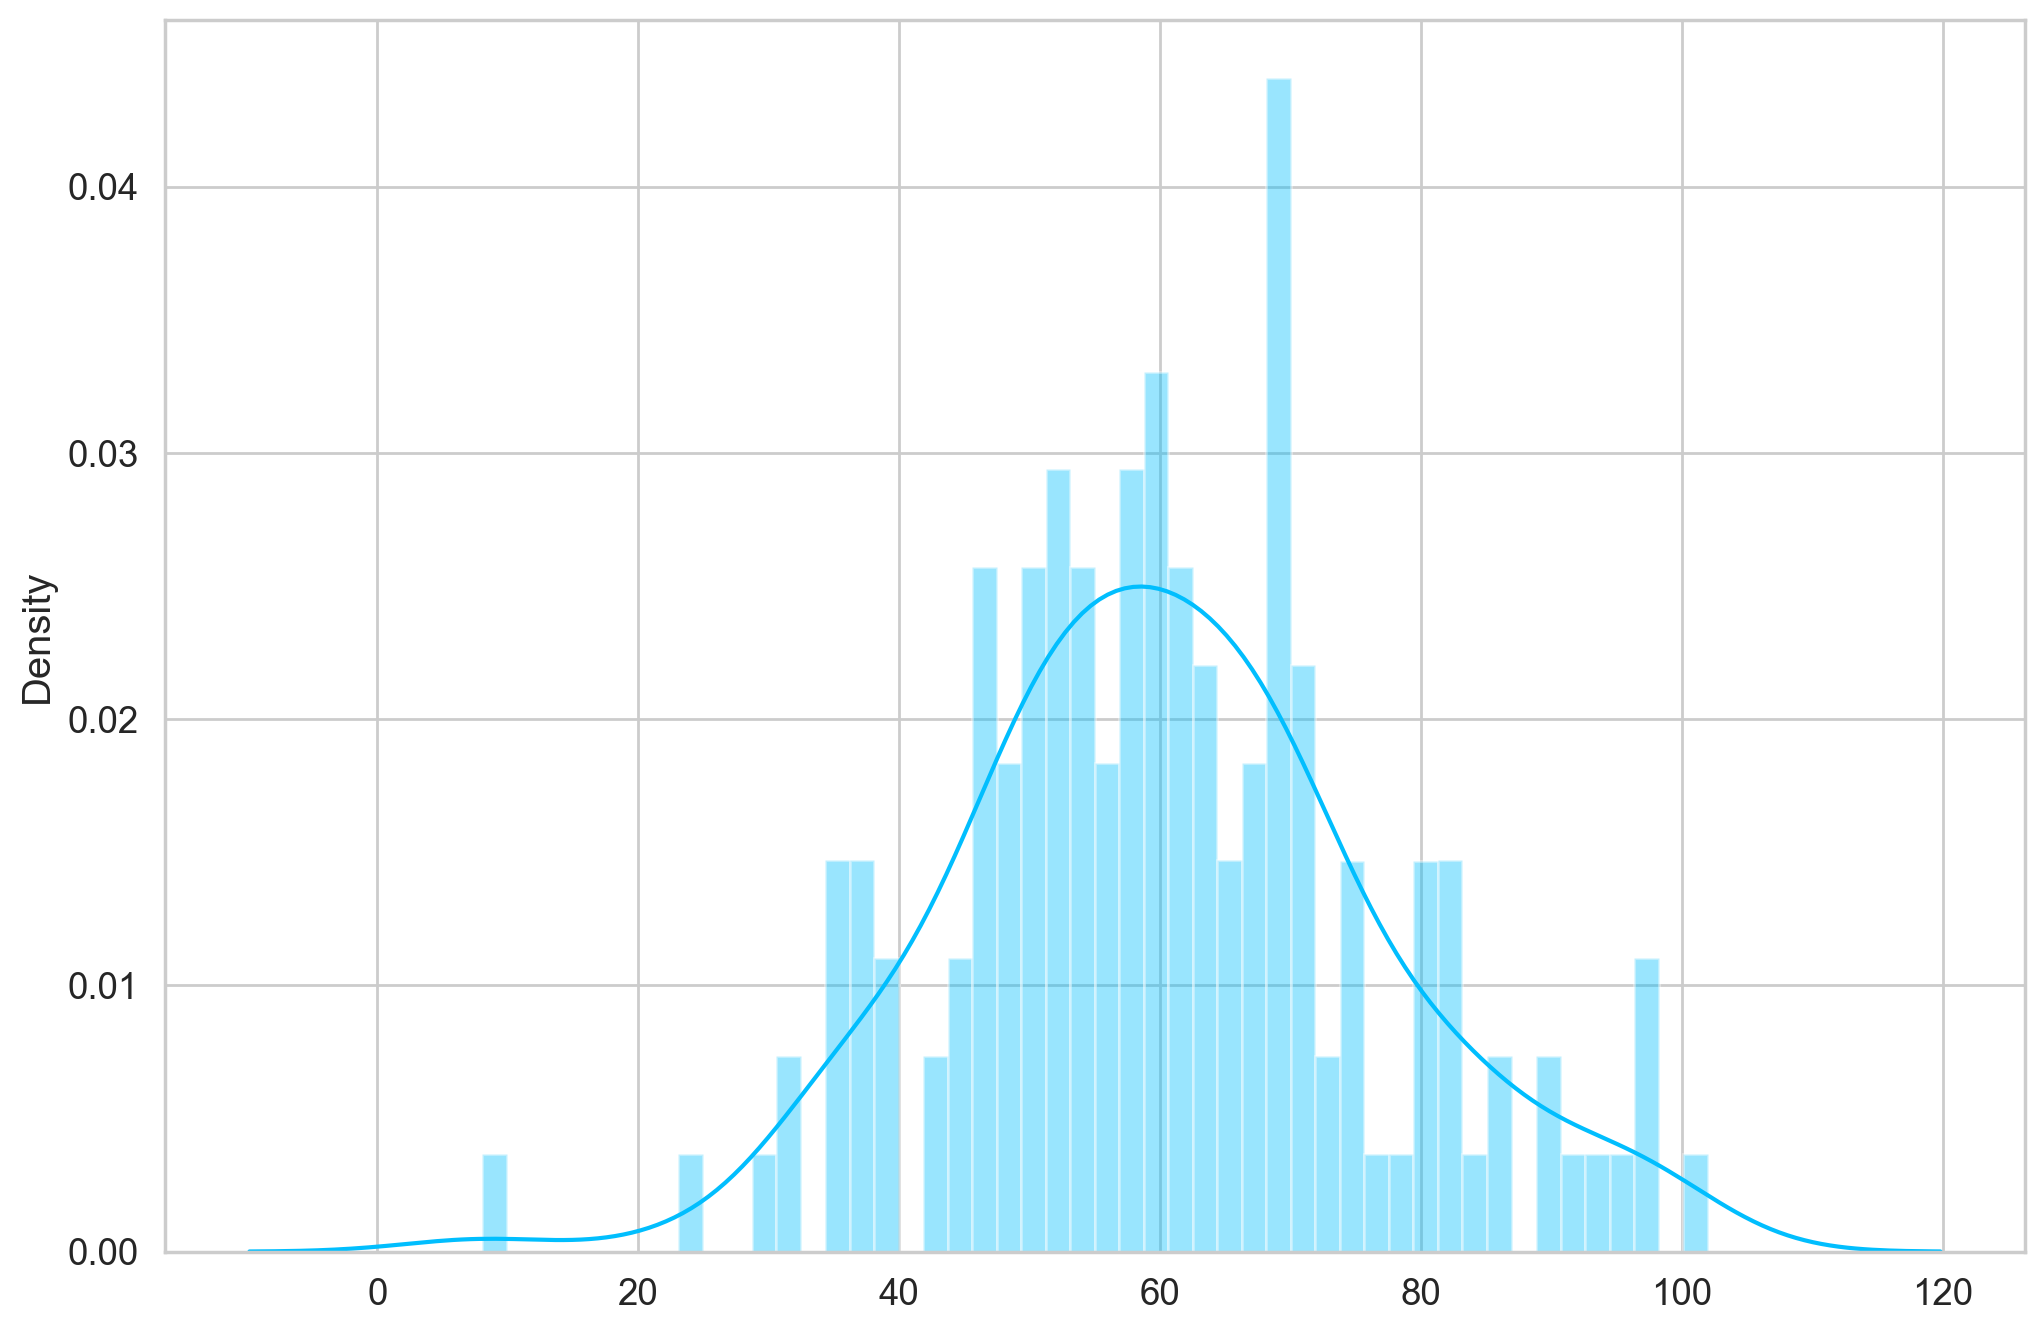

In [142]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins = 50, kde = True)

Finally, we can count the number of examples above the threshold (considered as anomalies)

In [143]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f"Correct anomaly predictions: {correct} / {len(anomaly_dataset)}") 

Correct anomaly predictions: 143 / 145


The predictions looks good. We can also change the threshold depending on what kind of errors you want to tolerate. In this case, we might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal). In this case, we need better recalls.

We can overlay the real and reconstructed Times Series values to see how close they are. We'll do it for some normal and anomaly cases.

In [144]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

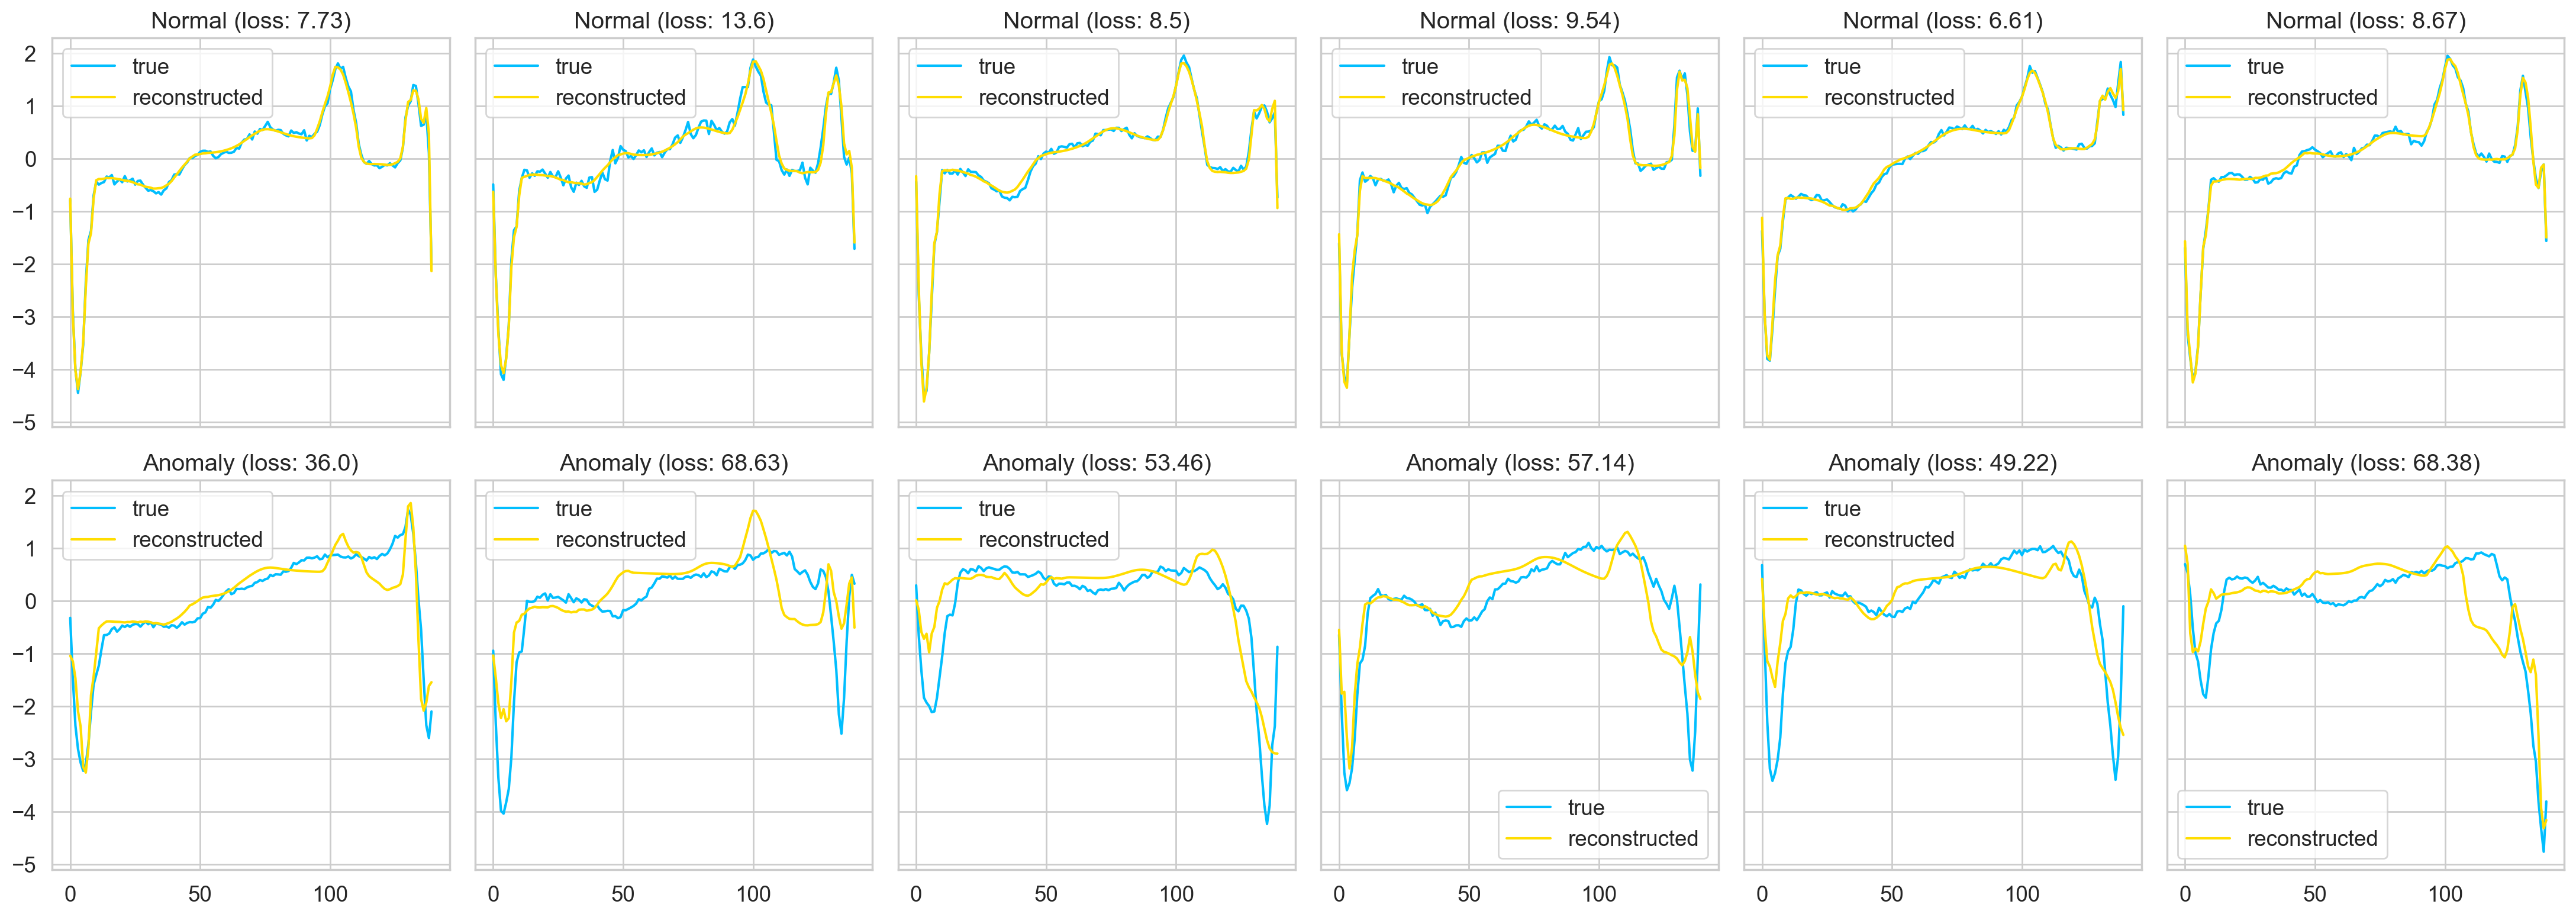

In [145]:

fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

Thus, we can see that the normal is very well predicted but the anomalies dataset do not fit very well with the reconstructed data which shows us the anomaly in the heart beat. Thus our model is performing very well.